# Importing Data


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip drive/MyDrive/Market-1501.zip

Streaming output truncated to the last 5000 lines.
  inflating: Market-1501-v15.09.15/gt_query/1180_c2s2_164677_00_junk.mat  
  inflating: Market-1501-v15.09.15/gt_query/1180_c3s3_006062_00_good.mat  
  inflating: Market-1501-v15.09.15/gt_query/1180_c3s3_006062_00_junk.mat  
  inflating: Market-1501-v15.09.15/gt_query/1180_c4s5_038360_00_good.mat  
  inflating: Market-1501-v15.09.15/gt_query/1180_c4s5_038360_00_junk.mat  
  inflating: Market-1501-v15.09.15/gt_query/1180_c5s3_006593_00_good.mat  
  inflating: Market-1501-v15.09.15/gt_query/1180_c5s3_006593_00_junk.mat  
  inflating: Market-1501-v15.09.15/gt_query/1180_c6s3_029892_00_good.mat  
  inflating: Market-1501-v15.09.15/gt_query/1180_c6s3_029892_00_junk.mat  
  inflating: Market-1501-v15.09.15/gt_query/1181_c1s5_041166_00_good.mat  
  inflating: Market-1501-v15.09.15/gt_query/1181_c1s5_041166_00_junk.mat  
  inflating: Market-1501-v15.09.15/gt_query/1181_c2s3_000162_00_good.mat  
  inflating: Market-1501-v15.09.15/gt_query/1181_

# Importing Dependices

In [3]:
import torch
from torch import optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Preprocessing

In [4]:
import os
from shutil import copyfile

download_path = '/content/Market-1501-v15.09.15'

if not os.path.isdir(download_path):
    print('Please change the download_path')

save_path = download_path + '/final_dataset'
if not os.path.isdir(save_path):
    os.mkdir(save_path)

# Query
query_path = download_path + '/query'
query_save_path = download_path + '/final_dataset/query'
if not os.path.isdir(query_save_path):
    os.mkdir(query_save_path)

for root, dirs, files in os.walk(query_path, topdown=True):
    for name in files:
        if not name[-3:] == 'jpg':
            continue
        ID = name.split('_')
        src_path = os.path.join(query_path, name)
        dst_path = os.path.join(query_save_path, ID[0])
        if not os.path.isdir(dst_path):
            os.mkdir(dst_path)
        copyfile(src_path, os.path.join(dst_path, name))

# Gallery
gallery_path = download_path + '/bounding_box_test'
gallery_save_path = download_path + '/final_dataset/gallery'
if not os.path.isdir(gallery_save_path):
    os.mkdir(gallery_save_path)

for root, dirs, files in os.walk(gallery_path, topdown=True):
    for name in files:
        if not name[-3:] == 'jpg':
            continue
        ID = name.split('_')
        src_path = os.path.join(gallery_path, name)
        dst_path = os.path.join(gallery_save_path, ID[0])
        if not os.path.isdir(dst_path):
            os.mkdir(dst_path)
        copyfile(src_path, os.path.join(dst_path, name))

# Train All
train_path = download_path + '/bounding_box_train'
train_save_path = download_path + '/final_dataset/train_all'
if not os.path.isdir(train_save_path):
    os.mkdir(train_save_path)

for root, dirs, files in os.walk(train_path, topdown=True):
    for name in files:
        if not name[-3:] == 'jpg':
            continue
        ID = name.split('_')
        src_path = os.path.join(train_path, name)
        dst_path = os.path.join(train_save_path, ID[0])
        if not os.path.isdir(dst_path):
            os.mkdir(dst_path)
        copyfile(src_path, os.path.join(dst_path, name))

# Train and Validation Split
train_path = download_path + '/bounding_box_train'
train_save_path = download_path + '/final_dataset/train'
val_save_path = download_path + '/final_dataset/val'
if not os.path.isdir(train_save_path):
    os.mkdir(train_save_path)
    os.mkdir(val_save_path)

for root, dirs, files in os.walk(train_path, topdown=True):
    for name in files:
        if not name[-3:] == 'jpg':
            continue
        ID = name.split('_')
        src_path = os.path.join(train_path, name)
        dst_path = os.path.join(train_save_path, ID[0])
        if not os.path.isdir(dst_path):
            os.mkdir(dst_path)
            dst_path = os.path.join(val_save_path, ID[0])
            os.mkdir(dst_path)
        copyfile(src_path, os.path.join(dst_path, name))


In [5]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
h, w = 256, 128
transform_train = transforms.Compose([
    transforms.Resize((h, w), interpolation=3),
    transforms.Pad(10),
    transforms.RandomCrop((h, w)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((h, w), interpolation=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Creating Dataloaders

In [6]:
train_dir = '/content/Market-1501-v15.09.15/final_dataset/train'
val_dir = '/content/Market-1501-v15.09.15/final_dataset/val'


batch_size = 32

train_dataset = ImageFolder(train_dir, transform=transform_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = ImageFolder(val_dir, transform=transform_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

# Building the Model

In [7]:
import torch.nn as nn
from torchvision import models


class ResNet50Model(nn.Module):
    def __init__(self, class_num):
        super(ResNet50Model, self).__init__()
        # Load the model
        model_ft = models.resnet50(pretrained=True)
        model_ft.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.model = model_ft
        self.classifier = nn.Linear(2048, class_num)

    def forward(self, x):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)
        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)
        x = self.model.avgpool(x)
        x = torch.squeeze(x)
        x = self.classifier(x)
        return x

# Training the Model

In [8]:
train_loss=[]
train_acc=[]
val_loss=[]
val_acc=[]

In [9]:
model = ResNet50Model(class_num=751)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

num_epochs = 20
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)


def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    correct = (preds == labels).sum().item()
    return correct / labels.size(0)

# Training loop
for epoch in range(num_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += calculate_accuracy(outputs, labels) * inputs.size(0)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects / dataset_sizes[phase]

        if phase == 'train':
            print(f'Epoch {epoch}/{num_epochs - 1} - {phase} Train Loss: {epoch_loss:.4f} Train Acc: {epoch_acc:.4f}')
            train_loss.append(epoch_loss)
            train_acc.append(epoch_acc)
        else:
            print(f'Val Loss: {epoch_loss:.4f} Val Acc: {epoch_acc:.4f}')
            val_loss.append(epoch_loss)
            val_acc.append(epoch_acc)

print('Training complete')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 47.1MB/s]


Epoch 0/19 - train Train Loss: 6.2828 Train Acc: 0.0312
Val Loss: 6.2402 Val Acc: 0.0399
Epoch 1/19 - train Train Loss: 5.1421 Train Acc: 0.1483
Val Loss: 5.3689 Val Acc: 0.0959
Epoch 2/19 - train Train Loss: 4.0602 Train Acc: 0.3018
Val Loss: 4.5170 Val Acc: 0.2037
Epoch 3/19 - train Train Loss: 3.1817 Train Acc: 0.4478
Val Loss: 3.7834 Val Acc: 0.3116
Epoch 4/19 - train Train Loss: 2.4927 Train Acc: 0.5733
Val Loss: 3.1704 Val Acc: 0.4181
Epoch 5/19 - train Train Loss: 1.9587 Train Acc: 0.6706
Val Loss: 2.6403 Val Acc: 0.5060
Epoch 6/19 - train Train Loss: 1.5627 Train Acc: 0.7444
Val Loss: 2.2196 Val Acc: 0.5899
Epoch 7/19 - train Train Loss: 1.2477 Train Acc: 0.8021
Val Loss: 1.8918 Val Acc: 0.6511
Epoch 8/19 - train Train Loss: 1.0023 Train Acc: 0.8459
Val Loss: 1.5955 Val Acc: 0.7057
Epoch 9/19 - train Train Loss: 0.8146 Train Acc: 0.8847
Val Loss: 1.3689 Val Acc: 0.7457
Epoch 10/19 - train Train Loss: 0.6607 Train Acc: 0.9096
Val Loss: 1.1946 Val Acc: 0.7656
Epoch 11/19 - train 

# Plotting the Graphs

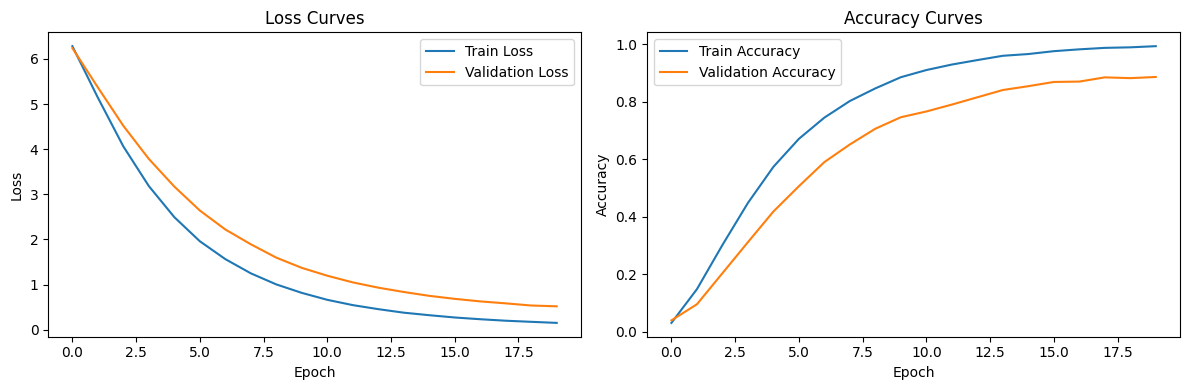

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')

# Plot accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')

# Show the plots
plt.tight_layout()
plt.show()

# Saving the Model

In [11]:
model_save_path = '/content/drive/MyDrive/ReID_20.pth'
torch.save(model.state_dict(), model_save_path)

# Evaluation

In [12]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch import optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_load_path = '/content/drive/MyDrive/ReID_20.pth'
model = ResNet50Model(class_num=751)
model.load_state_dict(torch.load(model_load_path))
model.to(device)
model.eval()


ResNet50Model(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [13]:
test_gallery_dir = '/content/Market-1501-v15.09.15/final_dataset/gallery'
test_query_dir = '/content/Market-1501-v15.09.15/final_dataset/query'
h, w = 256, 128
transform_test = transforms.Compose([
    transforms.Resize((h, w), interpolation=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_gallery_dataset = ImageFolder(test_gallery_dir, transform=transform_test)
test_query_dataset = ImageFolder(test_query_dir, transform=transform_test)

test_gallery_loader = DataLoader(test_gallery_dataset, batch_size=2, shuffle=False)
test_query_loader = DataLoader(test_query_dataset, batch_size=2, shuffle=False)


In [14]:
def sort_img(qf, ql, qc, gf, gl, gc):
    qf = np.array(qf)
    ql = np.array(ql)
    qc = np.array(qc)
    gf = np.array(gf)
    gl = np.array(gl)
    gc = np.array(gc)

    query = qf.reshape(-1, 1)
    score = np.dot(gf, query)
    score = score.squeeze(1)

    index = np.argsort(score)[::-1]

    query_index = np.argwhere(gl == ql)
    camera_index = np.argwhere(gc == qc)

    junk_index1 = np.argwhere(gl == -1)
    junk_index2 = np.intersect1d(query_index, camera_index)
    junk_index = np.append(junk_index2, junk_index1)

    mask = np.in1d(index, junk_index, invert=True)
    index = index[mask]
    return index

In [15]:
import os
import torch
from torch.utils.data import DataLoader
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import argparse
batch_size=32


transform_test = transforms.Compose([
    transforms.Resize((h, w), interpolation=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


test_gallery_dir = '/content/Market-1501-v15.09.15/final_dataset/gallery'
test_query_dir = '/content/Market-1501-v15.09.15/final_dataset/query'


test_gallery_dataset = ImageFolder(test_gallery_dir, transform=transform_test)
test_query_dataset = ImageFolder(test_query_dir, transform=transform_test)

test_gallery_loader = DataLoader(test_gallery_dataset, batch_size=batch_size, shuffle=False)
test_query_loader = DataLoader(test_query_dataset, batch_size=batch_size, shuffle=False)


gallery_cameras = []
query_cameras = []

for root, dirs, files in os.walk(test_gallery_dir):
    for dir in dirs:
        camera_id = dir
        gallery_cameras.append(camera_id)

for root, dirs, files in os.walk(test_query_dir):
    for dir in dirs:
        camera_id = dir
        query_cameras.append(camera_id)
model.eval()

query_features = []
query_labels = []
gallery_features = []
gallery_labels = []

with torch.no_grad():
    model.eval()

    for inputs, labels in test_query_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        query_features.extend(outputs.cpu().numpy())
        query_labels.extend(labels.cpu().numpy())

    for inputs, labels in test_gallery_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        gallery_features.extend(outputs.cpu().numpy())
        gallery_labels.extend(labels.cpu().numpy())

/content/Market-1501-v15.09.15/final_dataset/query/0001/0001_c2s1_000301_00.jpg
Top 10 images are as follows:


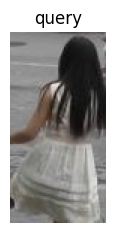

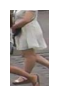

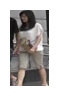

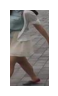

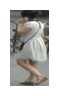

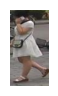

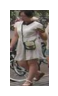

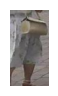

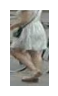

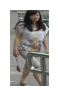

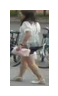

In [17]:
def imshow(path, title=None):
    im = plt.imread(path)
    plt.imshow(im)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_top_ranked_images(query_index, query_features, query_labels, query_cameras, gallery_features, gallery_labels, gallery_cameras):
    i = query_index
    index = sort_img(query_features[i], query_labels[i], query_cameras[i], gallery_features, gallery_labels, gallery_cameras)

    query_path = test_query_dataset.samples[i][0]
    query_label = query_labels[i]

    print(query_path)
    print('Top 10 images are as follows:')

    try:
        fig = plt.figure(figsize=(16, 4))
        ax = plt.subplot(1, 11, 1)
        ax.axis('off')
        imshow(query_path, 'query')

        for i in range(10):
            ax = plt.subplot(1, 11, i + 2)
            ax.axis('off')
            img_path = test_gallery_dataset.samples[index[i]][0]
            label = gallery_labels[index[i]]
            imshow(img_path)

            if label == query_label:
                ax.set_title('%d' % (i + 1), color='green')
            else:
                ax.set_title('%d' % (i + 1), color='red')
            # print(img_path)

    except RuntimeError:
        for i in range(10):
            img_path = test_gallery_dataset.samples[index[i]][0]
        print('If you want to see the visualization of the ranking result, a graphical user interface is needed.')
    fig.savefig("show.png")
show_top_ranked_images(1, query_features, query_labels, query_cameras, gallery_features, gallery_labels, gallery_cameras)